[Reference](https://medium.com/mlearning-ai/predicting-store-sales-random-forest-regression-b77abec64c17)

# Load in Data

In [1]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as a dataframe
features = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/random_forest_explained/data/temps_extended.csv')

# Data Preparation

In [2]:
# One Hot Encoding
features = pd.get_dummies(features)

# Extract features and labels
labels = features['actual']
features = features.drop('actual', axis = 1)

In [3]:
# Names of six features accounting for 95% of total importance
important_feature_names = ['temp_1', 'average', 'ws_1', 'temp_2', 'friend', 'year']

# Update feature list for visualizations
feature_list = important_feature_names[:]

features = features[important_feature_names]
features.head(5)

,temp_1,average,ws_1,temp_2,friend,year
0,37,45.6,4.92,36,40,2011
1,40,45.7,5.37,37,50,2011
2,39,45.8,6.26,40,42,2011
3,42,45.9,5.59,39,59,2011
4,38,46.0,3.80,42,39,2011


In [4]:
labels[1:6]

1    39
2    42
3    38
4    45
5    49
Name: actual, dtype: int64

In [5]:
# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [6]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1643, 6)
Training Labels Shape: (1643,)
Testing Features Shape: (548, 6)
Testing Labels Shape: (548,)


In [8]:
print('{:0.1f} years of data in the training set'.format(train_features.shape[0] / 365.))
print('{:0.1f} years of data in the test set'.format(test_features.shape[0] / 365.))

4.5 years of data in the training set
1.5 years of data in the test set


## Examine the Default Random Forest to Determine Parameters

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


# Random Search with Cross Validation


In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(train_features, train_labels);

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [12]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

In [13]:
rf_random.cv_results_

{'mean_fit_time': array([ 1.82201203,  9.86812162,  3.91645018, 13.6840659 ,  5.95950985,
         2.82232499,  3.90149554,  2.17751487, 11.19001349, 14.94950024,
         3.46209399,  5.6915106 ,  6.29209121,  6.71696742,  3.29132684,
        11.73760358,  3.92679334,  3.6124657 , 10.56724381,  3.20066118,
         6.3517007 ,  5.83340303,  4.72770325, 14.04673179,  7.84529718,
         2.64005295, 12.21007975,  3.01809613, 12.81278086,  4.78450553,
         4.84467808,  3.08811148,  3.66358256,  3.14541364,  5.44032486,
         3.305245  ,  7.09150179,  6.27450323,  4.03116218,  3.17159398,
         0.87710834,  1.76455585,  2.29402439,  1.29723907,  1.93566632,
         3.60539889, 10.37596035,  1.14709115,  4.81624524,  3.27625338,
        24.6485366 , 17.94080989,  7.17273911,  6.30437311,  7.95795965,
         2.18468277, 13.27877665, 15.27389717, 13.31837948,  6.03772084,
         1.06786768,  1.11624018,  7.0262483 , 12.548136  ,  7.65060782,
        10.66308014, 11.37052854, 

# Evaluation Function

In [14]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

## Evaluate the Default Model


In [15]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(train_features, train_labels)
base_accuracy = evaluate(base_model, test_features, test_labels)

Model Performance
Average Error: 3.9170 degrees.
Accuracy = 93.36%.


## Evaluate the Best Random Search Model


In [16]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, test_features, test_labels)

Model Performance
Average Error: 3.7159 degrees.
Accuracy = 93.73%.


In [17]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.39%.


# Grid Search



In [18]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

In [19]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 288 candidates, totalling 864 fits


In [20]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}

## Evaluate the Best Model from Grid Search


In [21]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

Model Performance
Average Error: 3.6565 degrees.
Accuracy = 93.83%.


In [22]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.39%.


# Another Grid Search

In [23]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a base model
rf = RandomForestRegressor(random_state = 42)

# Instantiate the grid search model
grid_search_final = GridSearchCV(estimator = rf, param_grid = param_grid, 
                                 cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)

grid_search_final.fit(train_features, train_labels);

Fitting 3 folds for each of 54 candidates, totalling 162 fits


In [24]:
grid_search_final.best_params_

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 6,
 'min_samples_split': 10,
 'n_estimators': 100}

In [25]:
best_grid_final = grid_search_final.best_estimator_
grid_final_accuracy = evaluate(best_grid_final, test_features, test_labels)

Model Performance
Average Error: 3.6590 degrees.
Accuracy = 93.82%.


In [26]:
print('Improvement of {:0.2f}%.'.format( 100 * (grid_final_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.49%.


# Final Model

In [27]:
final_model = grid_search.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = evaluate(final_model, test_features, test_labels)

Final Model Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 80,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


Model Performance
Average Error: 3.6565 degrees.
Accuracy = 93.83%.


#Comparison of All Improvement Techniques



In [28]:
# Time used for evaluating model run times
import time

In [29]:
# Evaluate run time and prediction accuracy
def evaluate_model(model, x_train, y_train, x_test, y_test):
    n_trees = model.get_params()['n_estimators']
    n_features = x_train.shape[1]
    
    # Train and predict 10 times to evaluate time and accuracy
    predictions = []
    run_times = []
    for _ in range(10):
        start_time = time.time()
        model.fit(x_train, y_train)
        predictions.append(model.predict(x_test))
    
        end_time = time.time()
        run_times.append(end_time - start_time)
    
    # Run time and predictions need to be averaged
    run_time = np.mean(run_times)
    predictions = np.mean(np.array(predictions), axis = 0)
    
    # Calculate performance metrics
    errors = abs(predictions - y_test)
    mean_error = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    
    # Return results in a dictionary
    results = {'time': run_time, 'error': mean_error, 'accuracy': accuracy, 'n_trees': n_trees, 'n_features': n_features}
    
    return results    

## Baseline (Historical Average)


In [30]:
full_features = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/random_forest_explained/data/temps_extended.csv')
full_features = full_features.rename(columns = {'weekday': 'week'})
full_features = pd.get_dummies(full_features)

full_labels = full_features['actual']
full_features = full_features.drop('actual', axis = 1)

full_feature_list = list(full_features.columns)
important_feature_names = ['temp_1', 'average', 'ws_1', 'temp_2', 'friend', 'year']

full_features_train, full_features_test, full_labels_train, full_labels_test = train_test_split(full_features, full_labels, 
                                                                                                test_size = 0.25, random_state = 42)

baseline_preds = full_features_test['average']
baseline_errors = abs(baseline_preds - full_labels_test)
baseline_mean_error = np.mean(baseline_errors)
baseline_accuracy = 100 - (100 * np.mean(baseline_errors / full_labels_test))

In [31]:
baseline_results = {'model': 'average', 'time': np.nan, 'n_trees': np.nan, 'error': baseline_mean_error, 'accuracy': baseline_accuracy, 'n_features': 1}

## Model with One Year of Data

In [32]:
original_features = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/random_forest_explained/data/temps.csv')
original_features = pd.get_dummies(original_features)

original_labels = np.array(original_features['actual'])
original_features= original_features.drop('actual', axis = 1)

original_feature_list = list(original_features.columns)
original_features = np.array(original_features)

original_train_features, original_test_features, original_train_labels, original_test_labels = train_test_split(original_features, original_labels, test_size = 0.25, random_state = 42)

# Need to keep only those features the one year model was trained on
one_test_features = full_features_test[original_feature_list]
one_test_features = np.array(one_test_features)

full_labels_test = np.array(full_labels_test)

# Default model
rf = RandomForestRegressor(n_estimators= 10, random_state=42)

# Results for model trained on one year of data
one_year_results = evaluate_model(rf, original_train_features, original_train_labels, one_test_features, full_labels_test)
one_year_results['model'] = 'one_year'                    

In [33]:
one_year_results

{'accuracy': 92.47743144949841,
 'error': 4.333394160583941,
 'model': 'one_year',
 'n_features': 14,
 'n_trees': 10,
 'time': 0.021367859840393067}

## Model with 4.5 Years of Training Data and All Features

In [34]:
full_features_train = np.array(full_features_train)
full_features_test = np.array(full_features_test)
full_labels_train = np.array(full_labels_train)
full_labels_test = np.array(full_labels_test)

In [35]:
four_year_results = evaluate_model(rf, full_features_train, full_labels_train, full_features_test, full_labels_test)
four_year_results['model'] = 'four_years_all'

In [36]:
four_year_results

{'accuracy': 93.50721966215396,
 'error': 3.8375912408759123,
 'model': 'four_years_all',
 'n_features': 17,
 'n_trees': 10,
 'time': 0.08636653423309326}

## Model with 4.5 Years of Training Data and Most Important Features

In [37]:
important_feature_indices = [full_feature_list.index(feature) for feature in important_feature_names]

In [38]:
train_features = full_features_train[:, important_feature_indices]
test_features = full_features_test[:, important_feature_indices]

train_labels = full_labels_train[:]
test_labels = full_labels_test[:]

In [39]:
four_years_important_results = evaluate_model(rf, train_features, train_labels, test_features, test_labels)
four_years_important_results['model'] = 'four_years_red'

In [40]:
four_years_important_results

{'accuracy': 93.36397494711629,
 'error': 3.916970802919708,
 'model': 'four_years_red',
 'n_features': 6,
 'n_trees': 10,
 'time': 0.059804248809814456}

## Random Search Best Model 

In [41]:
random_results = evaluate_model(best_random, train_features, train_labels, test_features, test_labels)
random_results['model'] = 'best_random'
random_results

{'accuracy': 93.73217652563157,
 'error': 3.7158933614831855,
 'model': 'best_random',
 'n_features': 6,
 'n_trees': 400,
 'time': 1.671981978416443}

## First Grid Search Best Model


In [42]:
first_grid_results = evaluate_model(best_grid, train_features, train_labels, test_features, test_labels)
first_grid_results['model'] = 'first_grid'
first_grid_results

{'accuracy': 93.82944978324339,
 'error': 3.6564575460524176,
 'model': 'first_grid',
 'n_features': 6,
 'n_trees': 100,
 'time': 0.27116096019744873}

## Second Grid Search Best Model

In [43]:
final_model_results = evaluate_model(best_grid_final, train_features, train_labels, test_features, test_labels)
final_model_results['model'] = 'second_grid'

In [44]:
final_model_results

{'accuracy': 93.81740203358855,
 'error': 3.659036439647158,
 'model': 'second_grid',
 'n_features': 6,
 'n_trees': 100,
 'time': 0.2661502599716187}

# Comparison

In [45]:
comparison = {'model': [baseline_results['model'], one_year_results['model']],
              'accuracy': [round(baseline_results['accuracy'], 3), round(one_year_results['accuracy'], 3)],
              'error': [round(baseline_results['error'], 3), round(one_year_results['error'], 3)],
              'n_features': [baseline_results['n_features'], one_year_results['n_features']],
              'n_trees': [baseline_results['n_trees'], int(one_year_results['n_trees'])],
              'time': [round(baseline_results['time'], 4), round(one_year_results['time'], 4)]}
                        
for model in [four_year_results, four_years_important_results, random_results, first_grid_results, final_model_results]:
    comparison['accuracy'].append(round(model['accuracy'], 3))
    comparison['error'].append(round(model['error'], 3))
    comparison['model'].append(model['model'])
    comparison['n_features'].append(model['n_features'])
    comparison['n_trees'].append(int(model['n_trees']))
    comparison['time'].append(round(model['time'], 4))

In [46]:
comparison = pd.DataFrame.from_dict(comparison, orient = 'columns')

In [47]:
comparison[['model', 'accuracy', 'error', 'n_features', 'n_trees', 'time']]

,model,accuracy,error,n_features,n_trees,time
0,average,91.961,4.763,1,NaN,NaN
1,one_year,92.477,4.333,14,10.0,0.0214
2,four_years_all,93.507,3.838,17,10.0,0.0864
3,four_years_red,93.364,3.917,6,10.0,0.0598
4,best_random,93.732,3.716,6,400.0,1.6720
5,first_grid,93.829,3.656,6,100.0,0.2712
6,second_grid,93.817,3.659,6,100.0,0.2662


In [48]:
print('Adding Data and Feature Selection error reduction: {:0.2f}%'.format(100 * (baseline_results['error'] - four_years_important_results['error']) / baseline_results['error'])) 
print('Hyperparameter Tuning Error Reduction: {:0.2f}%'.format(100 * (four_years_important_results['error'] - first_grid_results['error']) / four_years_important_results['error']))

Adding Data and Feature Selection error reduction: 17.76%
Hyperparameter Tuning Error Reduction: 6.65%


# Plotting 

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('fivethirtyeight')

## Model Comparison Plot

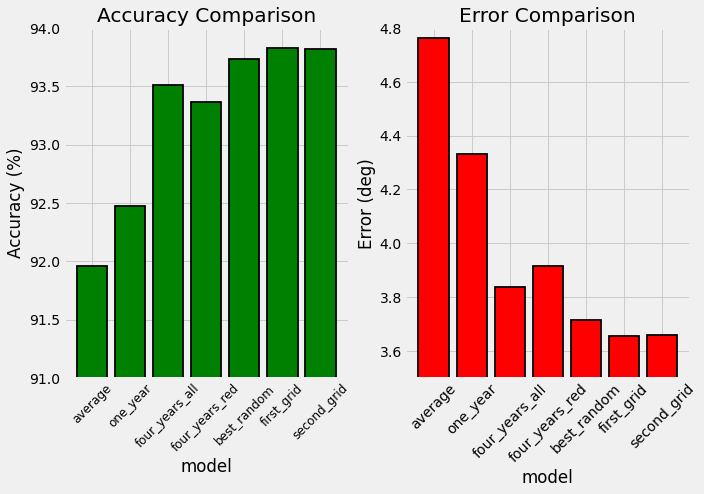

In [50]:
xvalues = list(range(len(comparison)))
plt.subplots(1, 2, figsize=(10, 6))
plt.subplot(121)
plt.bar(xvalues, comparison['accuracy'], color = 'g', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45, fontsize = 12)
plt.ylim(ymin = 91, ymax = 94)
plt.xlabel('model'); plt.ylabel('Accuracy (%)'); plt.title('Accuracy Comparison');

plt.subplot(122)
plt.bar(xvalues, comparison['error'], color = 'r', edgecolor = 'k', linewidth = 1.8)
plt.xticks(xvalues, comparison['model'], rotation = 45)
plt.ylim(ymin = 3.5, ymax = 4.8)
plt.xlabel('model'); plt.ylabel('Error (deg)'); plt.title('Error Comparison');
plt.show();

# Training Curves

In [51]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 301, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(train_features, train_labels);

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [52]:
tree_grid_search.cv_results_

{'mean_fit_time': array([0.00485341, 0.03886684, 0.07000748, 0.10738786, 0.14362892,
        0.16812229, 0.1937151 , 0.23337396, 0.26564185, 0.28987892,
        0.31885775, 0.3530612 , 0.38297002, 0.42633176, 0.44820412,
        0.47913591, 0.5173223 , 0.54376825, 0.58618371, 0.61010551,
        0.63893318, 0.66555293, 0.69772911, 0.73279087, 0.76708158,
        0.7857608 , 0.83123477, 0.85250314, 0.89210502, 0.89269241]),
 'mean_score_time': array([0.00100152, 0.00332276, 0.00498557, 0.00713666, 0.01307249,
        0.0113248 , 0.01329819, 0.0147349 , 0.01665235, 0.01905505,
        0.02088459, 0.02273417, 0.02496688, 0.02667514, 0.02957177,
        0.03367392, 0.03270117, 0.0350279 , 0.0366958 , 0.03921628,
        0.0434556 , 0.04301373, 0.04381847, 0.04679171, 0.04775174,
        0.05097524, 0.05251598, 0.05438455, 0.05941987, 0.05079206]),
 'mean_test_score': array([-4.66981492, -3.86445783, -3.83627   , -3.83846786, -3.81685444,
        -3.81216739, -3.81078847, -3.81450129, -3.81

In [53]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 2.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

In [54]:
plot_results(tree_grid_search)

KeyError: ignored

## Number of Features at Each Split

In [ ]:
# Define a grid over only the maximum number of features
feature_grid = {'max_features': list(range(1, train_features.shape[1] + 1))}

In [ ]:
# Create the grid search and fit on the training data
feature_grid_search = GridSearchCV(final_model, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'neg_mean_absolute_error')
feature_grid_search.fit(train_features, train_labels);

In [ ]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')

# Visualizing One Tree in the Forest

In [ ]:
# Use sklearn to export the tree 
from sklearn.tree import export_graphviz

# Write the decision tree as a dot file
visual_tree = final_model.estimators_[12]
export_graphviz(visual_tree, out_file = 'images/best_tree.dot', feature_names = important_feature_names, 
                precision = 2, filled = True, rounded = True, max_depth = None)

In [ ]:
# Use pydot for converting to an image file
import pydot

# Import the dot file to a graph and then convert to a png
(graph, ) = pydot.graph_from_dot_file('images/best_tree.dot')
graph.write_png('images/best_tree.png')